In [26]:
import os

import copy
import random
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd 

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, auc #, roc_curve, precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as st
from scipy.stats import norm
from tabulate import tabulate

from logging_utils import *
from logging_utils import myLogger, print_log, close_loggers 

from plot_utils import plot_mean_ROC, plot_mean_PR
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import scipy.stats as st
from scipy.stats import t
from scipy import stats

In [2]:
SEED = 1970
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

color_index = list(mcolors.CSS4_COLORS)
colors = mcolors.CSS4_COLORS

data_path = './data/'
mean_metrics = 'mean_metrics.csv'
mean_metrics_VA = 'mean_metrics_231231.csv'

mean_metrics_cols = ['date', 'model', 'image_size', 'batch_size', 'channel', 'test_set','roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metrics_cols = ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metric_name = ['ROC AUC', 'PR AUC', 'F1', 'Precision', 'Recall']
test_label = ['test_loc', 'test_NoL']
test_classes = {'test_loc' : [5812, 336], 'test_NoL' : [3742, 835]}

# channel_label = ['RGB', '3', 'EI', 'MI', '5']
channel_label = ['RGB', 'HSV', 'EI', 'MI', '5']
channel_label_alt = ['RGB', 'HSV', 'HSV + EI', 'HSV + MI', 'HSV + EI + MI']

In [3]:
df_mean_metrics = pd.read_csv(f'{data_path}/{mean_metrics}')
df_mean_metrics.shape

(150, 13)

In [4]:
df_mean_metrics_VA = pd.read_csv(f'{data_path}/{mean_metrics_VA}')
df_mean_metrics_VA.dropna(inplace = True)
df_mean_metrics_VA.shape

(100, 13)

In [5]:
df_mean_metrics.tail(10)

,date,model,image_size,batch_size,channel,roc_auc,pr_auc,f1,precision,recall,test_set,uuid,drop_luminance
140,20240106,v2b1,256,32,RGB,0.705036,0.411109,0.424054,0.373857,0.489820,test_NoL,1abf7438-997d-4ada-8cad-4cf4f389c644,1
141,20240106,v2b1,256,32,3,0.743448,0.451695,0.458498,0.390244,0.555689,test_NoL,1abf7438-997d-4ada-8cad-4cf4f389c644,1
142,20240106,v2b1,256,32,EI,0.725696,0.427837,0.441176,0.404595,0.485030,test_NoL,1abf7438-997d-4ada-8cad-4cf4f389c644,1
143,20240106,v2b1,256,32,MI,0.697491,0.408570,0.415170,0.355860,0.498204,test_NoL,1abf7438-997d-4ada-8cad-4cf4f389c644,1
144,20240106,v2b1,256,32,5,0.706058,0.418506,0.421890,0.346124,0.540120,test_NoL,1abf7438-997d-4ada-8cad-4cf4f389c644,1
145,20240106,v2b1,256,32,RGB,0.886585,0.380625,0.393975,0.322581,0.505952,test_loc,1abf7438-997d-4ada-8cad-4cf4f389c644,1
146,20240106,v2b1,256,32,3,0.858886,0.367827,0.365879,0.279435,0.529762,test_loc,1abf7438-997d-4ada-8cad-4cf4f389c644,1
147,20240106,v2b1,256,32,EI,0.868390,0.372907,0.376260,0.301616,0.500000,test_loc,1abf7438-997d-4ada-8cad-4cf4f389c644,1
148,20240106,v2b1,256,32,MI,0.876641,0.353446,0.366138,0.284072,0.514881,test_loc,1abf7438-997d-4ada-8cad-4cf4f389c644,1
149,20240106,v2b1,256,32,5,0.878624,0.346694,0.359081,0.276527,0.511905,test_loc,1abf7438-997d-4ada-8cad-4cf4f389c644,1


In [6]:
df_mean_metrics_VA.tail(10)

,date,model,image_size,batch_size,channel,roc_auc,pr_auc,f1,precision,recall,test_set,uuid,drop_luminance
130,20231223,vgg16,256,64,RGB,0.725670,0.421800,0.438517,0.352215,0.580838,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
131,20231223,vgg16,256,64,3,0.729804,0.433395,0.431764,0.323758,0.647904,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
132,20231223,vgg16,256,64,EI,0.718551,0.419581,0.427071,0.316244,0.657485,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
133,20231223,vgg16,256,64,MI,0.712765,0.417779,0.431955,0.352807,0.556886,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
134,20231223,vgg16,256,64,5,0.717374,0.413925,0.427350,0.323674,0.628743,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
135,20231223,vgg16,256,64,RGB,0.883910,0.410755,0.393684,0.304560,0.556548,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
136,20231223,vgg16,256,64,3,0.883286,0.382386,0.365572,0.260430,0.613095,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
137,20231223,vgg16,256,64,EI,0.884267,0.396170,0.372378,0.263614,0.633929,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
138,20231223,vgg16,256,64,MI,0.886443,0.397081,0.401309,0.316695,0.547619,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
139,20231223,vgg16,256,64,5,0.887158,0.392524,0.383459,0.280220,0.607143,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0


In [7]:
uuid_left = set(df_mean_metrics.uuid)
uuid_right = set(df_mean_metrics_VA.uuid)
uuid_add = uuid_right - uuid_left
# print(uuid_add)

df_mean_metrics_all = pd.concat([df_mean_metrics, df_mean_metrics_VA.loc[df_mean_metrics_VA.uuid.isin(uuid_add)]], axis = 0).reindex()
print(df_mean_metrics_all.shape[0])

250


In [8]:
df_mean_metrics_all.loc[df_mean_metrics_all.channel == '3', 'channel'] = 'HSV'
df_mean_metrics_all

,date,model,image_size,batch_size,channel,roc_auc,pr_auc,f1,precision,recall,test_set,uuid,drop_luminance
0,20231127,v1b0,256,128,RGB,0.693207,0.486560,0.415094,0.327562,0.566467,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f,0
1,20231127,v1b0,256,128,HSV,0.693431,0.483368,0.408954,0.319220,0.568862,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f,0
2,20231127,v1b0,256,128,EI,0.687453,0.470314,0.407180,0.336193,0.516168,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f,0
3,20231127,v1b0,256,128,MI,0.683484,0.478675,0.411845,0.332353,0.541317,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f,0
4,20231127,v1b0,256,128,5,0.691385,0.481461,0.407792,0.319322,0.564072,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,20231223,vgg16,256,64,RGB,0.883910,0.410755,0.393684,0.304560,0.556548,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
136,20231223,vgg16,256,64,HSV,0.883286,0.382386,0.365572,0.260430,0.613095,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
137,20231223,vgg16,256,64,EI,0.884267,0.396170,0.372378,0.263614,0.633929,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0
138,20231223,vgg16,256,64,MI,0.886443,0.397081,0.401309,0.316695,0.547619,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323,0


In [9]:
# df_mean_metrics_all.to_csv('./data/mean_metrics_combined_240117.csv', index = False)

In [10]:
def plot_metrics(df_mean_metrics):
    df_mean = df_mean_metrics.groupby(['test_set','channel'])['roc_auc'].mean()
    df_mean_all = df_mean_metrics.groupby(['test_set','channel'])[metrics_cols].mean()

    for mi, mn in enumerate(metrics_cols):  
        fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
        for ti, tn in enumerate(test_label):
            metrics_dict = dict(df_mean_all.loc[test_label[ti]][mn])
            rearr = {}
            for ch in channel_label:
                rearr[ch] = metrics_dict[ch]
            x = list(rearr.keys())
            y = list(rearr.values())
            max_x = np.argmax(y)
            max_y = np.array(y).max()
            ax.plot(max_x, max_y, marker = 'o')
            ax.plot(x, y,
                    color = colors[color_index[ti]],
                    label = f"{mn} for {tn}",
                    lw=2,
                    alpha = 0.9)   
        ax.set(xlabel = "Channels",
                ylabel = mn,
                title = f"Mean {mn} for all channels")   
        ax.legend(loc="lower right")
        plt.show()

In [11]:
def print_metrics_CI(df_mean_metrics_all):
    for ti, tn in enumerate(test_label):
        n_samples = df_mean_metrics_all.loc[(df_mean_metrics_all.test_set == tn)].shape[0]
        print(f'\nTest set - {tn}, {test_classes[tn][0]} bening and {test_classes[tn][1]} malignant samples')
        print(f'{n_samples//5} models results:')
        for mi, metr in enumerate(metrics_cols):
            print(f"{metric_name[mi]}")
            table = []
            m_values = np.zeros(5)
            for ci, ch in enumerate(channel_label):
                df_temp = df_mean_metrics_all.loc[(df_mean_metrics_all.test_set == tn) & (df_mean_metrics_all.channel == ch)]
                ci_metr = st.t.interval(0.95, df = (df_temp.shape[0])-1, loc=np.mean(df_temp[metr].values), scale=st.sem(df_temp[metr].values)) 
                table = table + [[channel_label_alt[ci], f'{np.mean(df_temp[metr].values) * 100:.2f}%', f'({ci_metr[0] * 100:.2f}%, {ci_metr[1] * 100:.2f}%)']]
                m_values[ci] = np.mean(df_temp[metr].values) * 100
            max_i = np.argmax(m_values)
            table[max_i][1] = '-> ' + table[max_i][1] + ' <-'
            print(tabulate(table, ['Channels', 'Mean','95% Confidence interval'], tablefmt="rounded_outline", colalign=('left', "center", "center")))

In [12]:
# print_metrics_CI(df_mean_metrics)

In [13]:
print_metrics_CI(df_mean_metrics_all)


Test set - test_loc, 5812 bening and 336 malignant samples
25 models results:
ROC AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │    86.75%    │     (86.03%, 87.48%)      │
│ HSV           │    86.70%    │     (86.27%, 87.14%)      │
│ HSV + EI      │    86.55%    │     (86.09%, 87.01%)      │
│ HSV + MI      │ -> 86.85% <- │     (86.32%, 87.37%)      │
│ HSV + EI + MI │    86.62%    │     (86.08%, 87.17%)      │
╰───────────────┴──────────────┴───────────────────────────╯
PR AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │ -> 34.77% <- │     (32.91%, 36.64%)      │
│ HSV           │    33.97%    │     (32.66%, 35.29%)      │
│ HSV + EI      │    34.18%    │     (32.73%, 35.64%

In [14]:
# plot_metrics(df_mean_metrics)

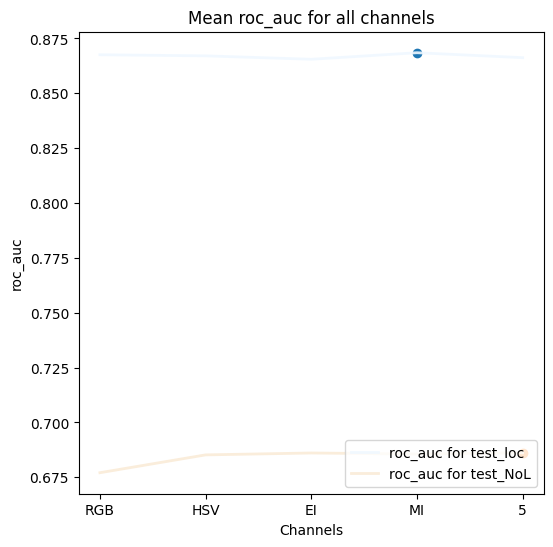

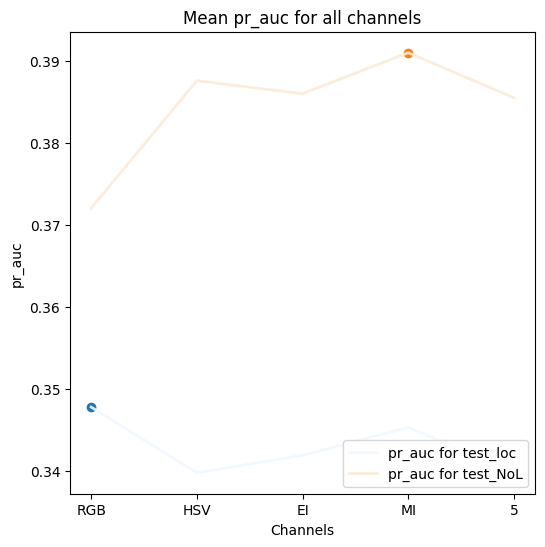

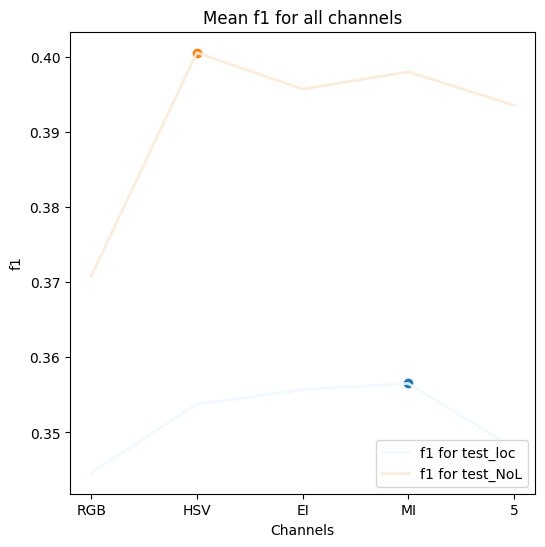

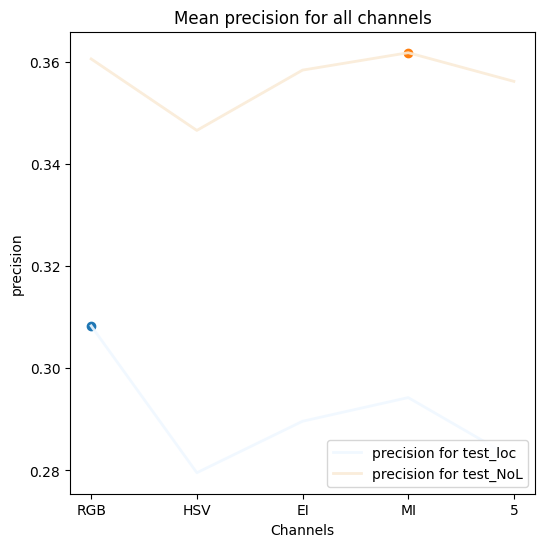

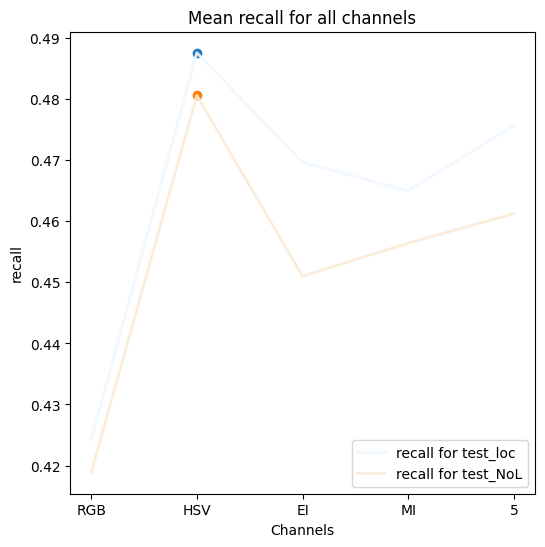

In [15]:
plot_metrics(df_mean_metrics_all)

[]

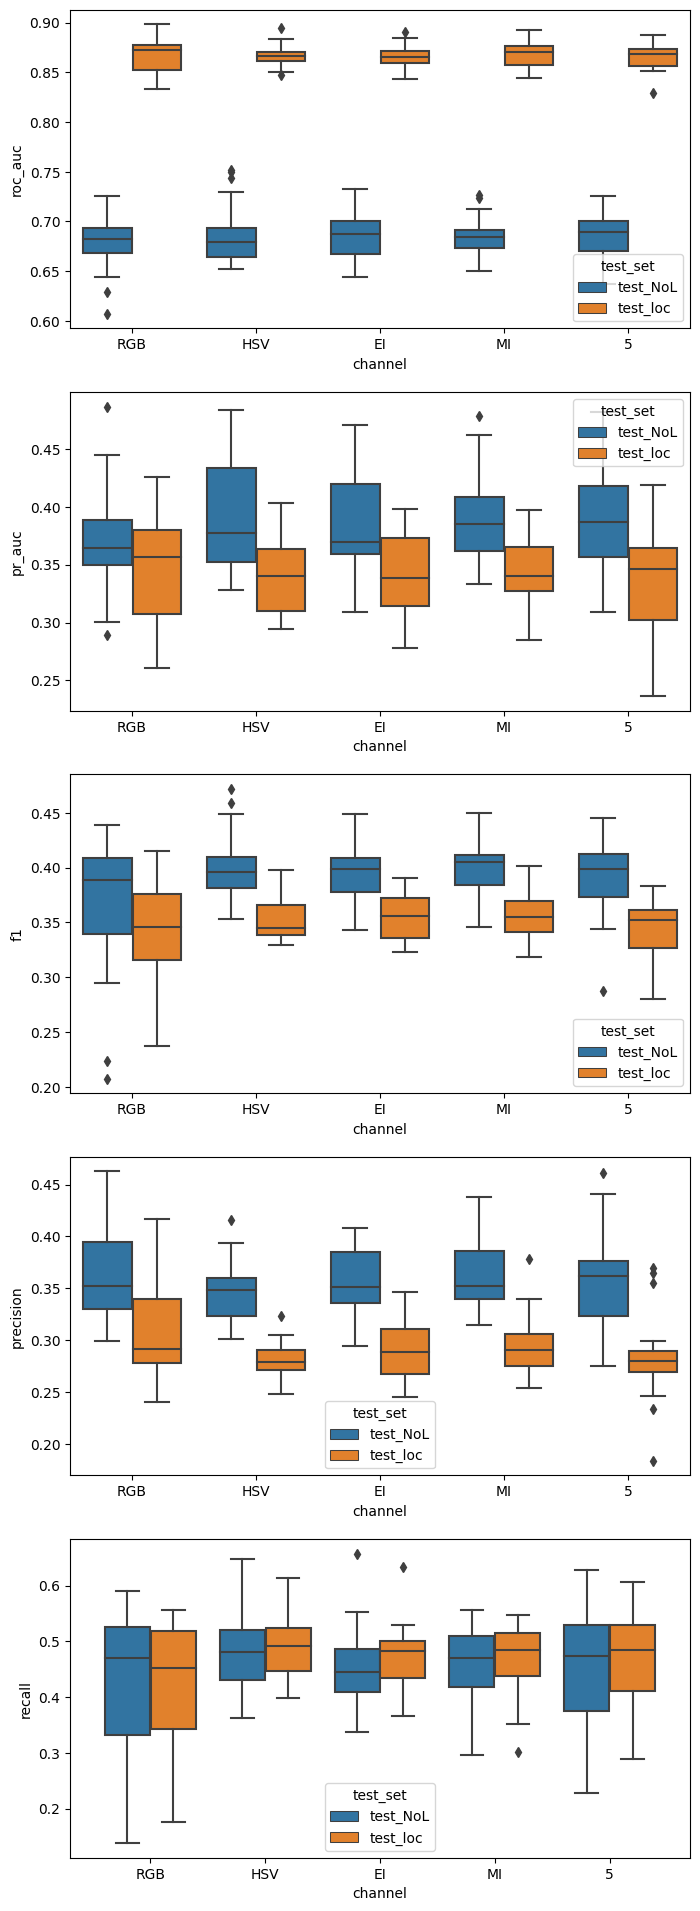

In [16]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 24))
for i, mtr in enumerate(metrics_cols):
    sns.boxplot(df_mean_metrics_all, x = 'channel', y = mtr, hue = 'test_set', ax = axs[i])

plt.plot()


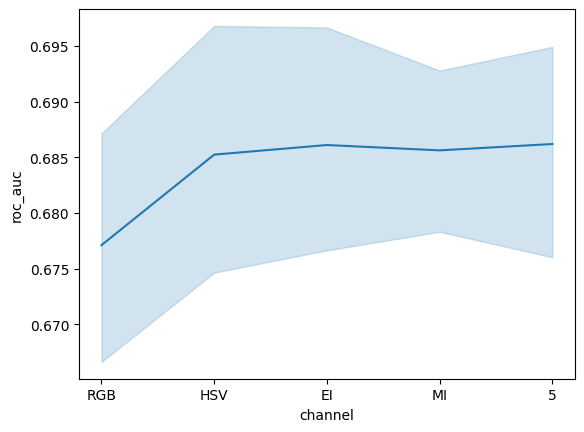

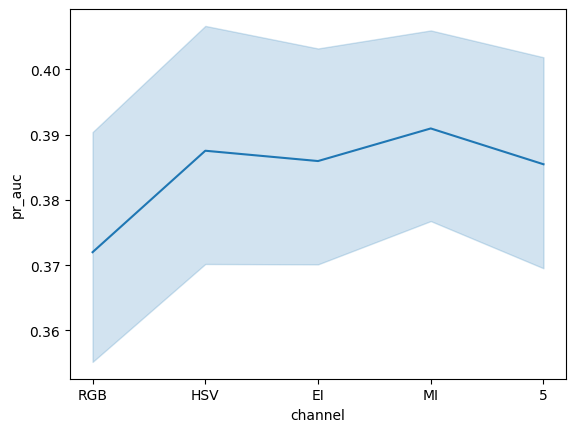

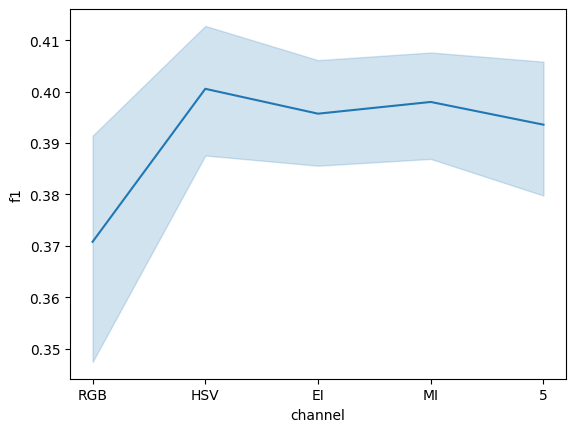

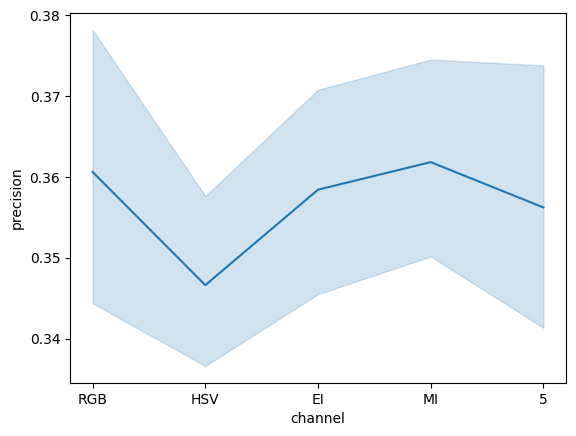

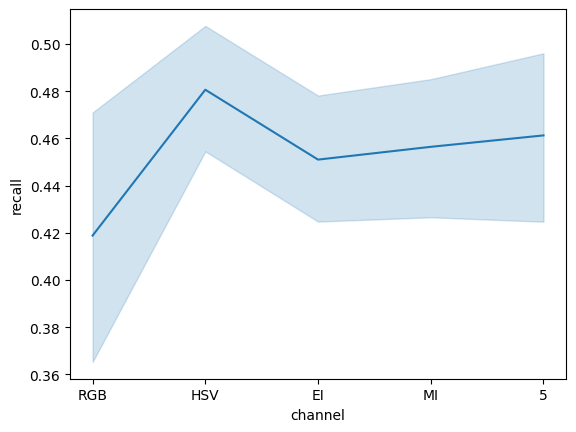

In [17]:
for metr in metrics_cols:
    sns.lineplot(data = df_mean_metrics_all.loc[df_mean_metrics_all.test_set == 'test_NoL'], x = "channel", y = metr)
    plt.show()

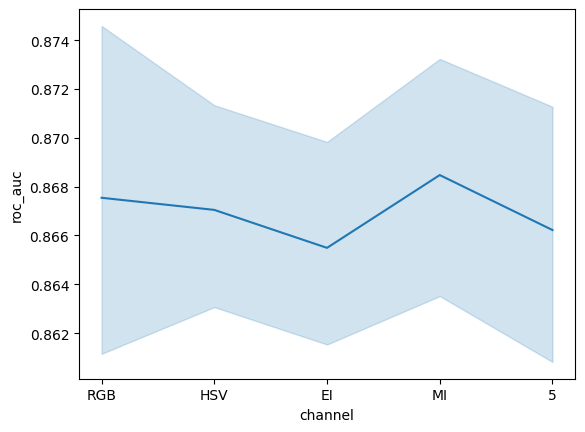

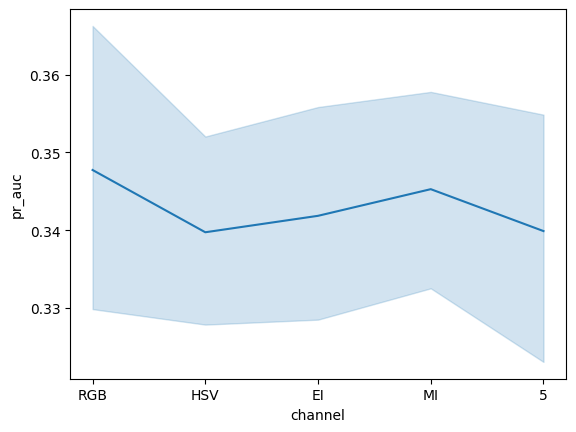

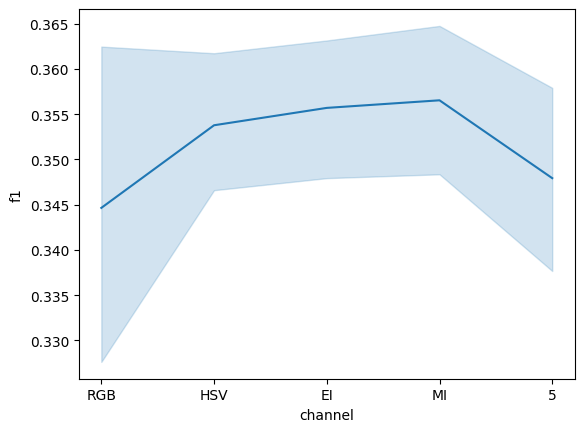

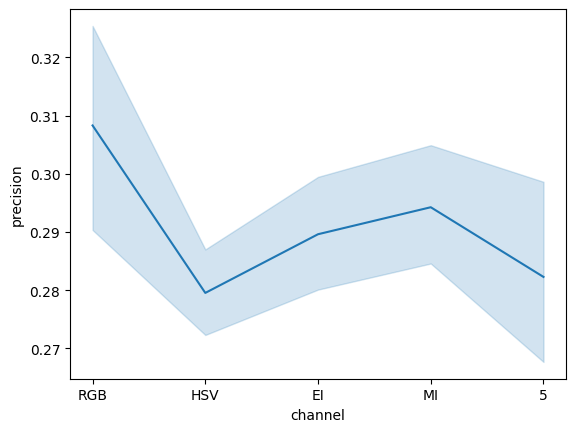

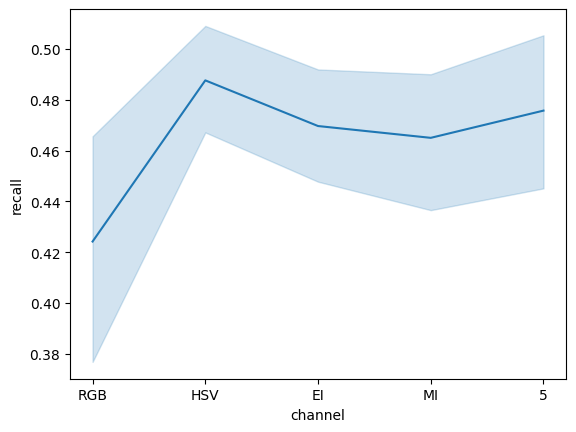

In [18]:
for metr in metrics_cols:
    sns.lineplot(data = df_mean_metrics_all.loc[df_mean_metrics_all.test_set == 'test_loc'], x = "channel", y = metr)
    plt.show()

In [35]:
def plot(models_res, ch1 = 'RGB', ch2 = 'HSV', test_set = 'test_loc'):
    print('Null hypothesis is that the means are indistinguishable. \n')
    df_metrics = models_res.loc[models_res.test_set == test_set]
    CV_ch1 = df_metrics.loc[df_metrics.channel == ch1]
    CV_ch2 = df_metrics.loc[df_metrics.channel == ch2]
    
    labels_all = [ch1, ch2]
    alpha = 0.05
    n_bins = 25
    
    print(f"Number of the data points for test set dataset: {CV_ch1.shape[0]}")
    
    n_points = CV_ch1.shape[0]
                                   
    # degrees of freedom
    df = n_points * 2 - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
    
    for n_metric in range(len(metrics_cols)):
#         n_metric = 1
        c_metric = metrics_cols[n_metric]

        CV_ch1_mean = CV_ch1[c_metric].mean()
        CV_ch2_mean = CV_ch2[c_metric].mean()
        CV_ch1_min = CV_ch1[c_metric].min()
        CV_ch2_min = CV_ch2[c_metric].min()

        colors = ['olive', 'skyblue']

        x = np.array([CV_ch1[c_metric].values, CV_ch2[c_metric].values]).T
        fig, ax1 = plt.subplots(layout='constrained', figsize=(8, 6))
        density_1 = st.gaussian_kde(CV_ch1[c_metric].values)
        density_2 = st.gaussian_kde(CV_ch2[c_metric].values)
        counts, bins, _ = ax1.hist(x, n_bins, density = False, histtype ='bar', color = colors, label = labels_all, alpha = 0.7)
        ax1.tick_params(axis='y', labelcolor = 'red')
        ax1.vlines(CV_ch1_mean, 0, counts.max() + 0.5, colors = ['greenyellow'])
        ax1.vlines(CV_ch2_mean, 0, counts.max() + 0.5, colors = ['steelblue'])
        ax1.text(0.05, 0.9, f'{c_metric} for {ch1} channels mean = {CV_ch1_mean:.4f}', transform=ax1.transAxes, color = 'yellowgreen')
        ax1.text(0.05, 0.85, f'{c_metric} for {ch2} channels mean = {CV_ch2_mean:.4f}', transform=ax1.transAxes, color = 'steelblue', zorder = 2)
        ax1.legend(loc = 'upper left', ncols = 2)
        ax1.set_xlabel(c_metric)
        ax1.set_ylabel('Counts')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(bins, density_1(bins), color = 'greenyellow')
        ax2.plot(bins, density_2(bins), color = 'steelblue')
        ax2.set_ylabel('Density')
        plt.title(f'Distribution of {c_metric} of {CV_ch1.shape[0]} models on {test_set} dataset - {ch1} channels vs {ch2} channels')
        plt.show()

        tstat_4, p4 = stats.ttest_ind(CV_ch1[c_metric].values, CV_ch2[c_metric].values)
        print(f"t-test for {ch2} vs {ch1} channels: t-statistic = {tstat_4:.2f}, p value = {p4:.4f}")
    #     interpret(tstat_4, p4, cv, alpha = 0.05)



Null hypothesis is that the means are indistinguishable. 

Number of the data points for test set dataset: 25
Degrees of freedom = 48, Critical Value = 1.6772 



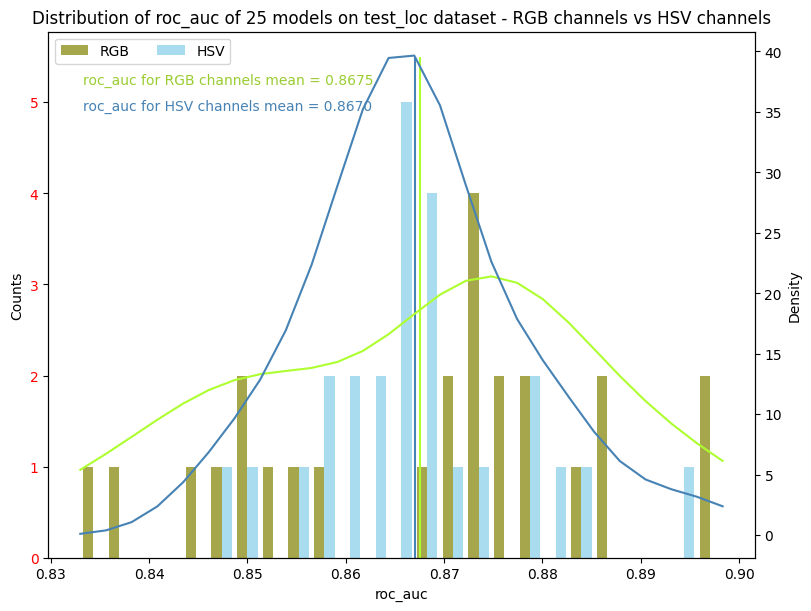

t test for HSV vs RGB channels: t-statistic = 0.12, p value = 0.9035


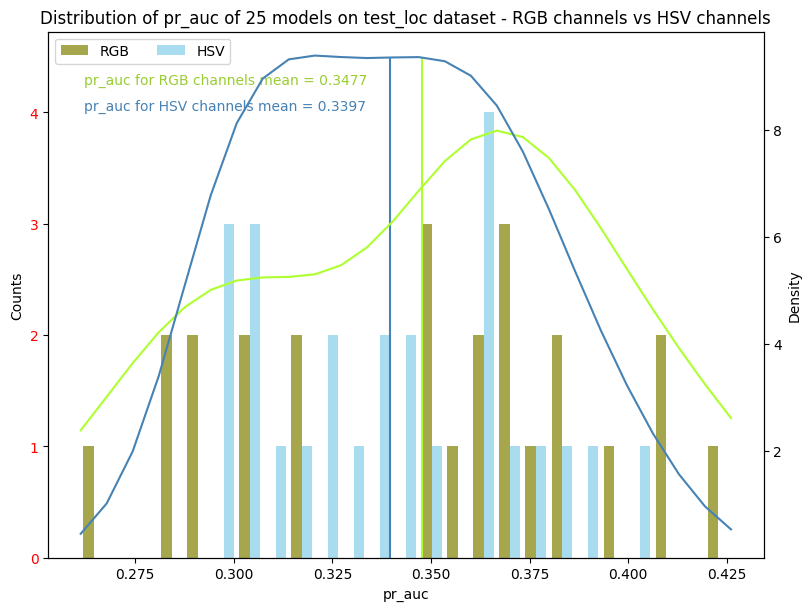

t test for HSV vs RGB channels: t-statistic = 0.72, p value = 0.4727


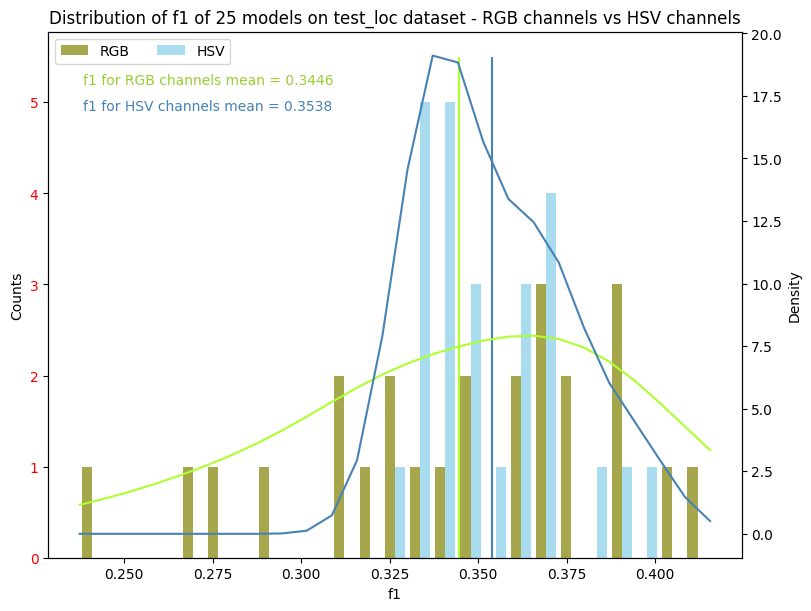

t test for HSV vs RGB channels: t-statistic = -0.93, p value = 0.3570


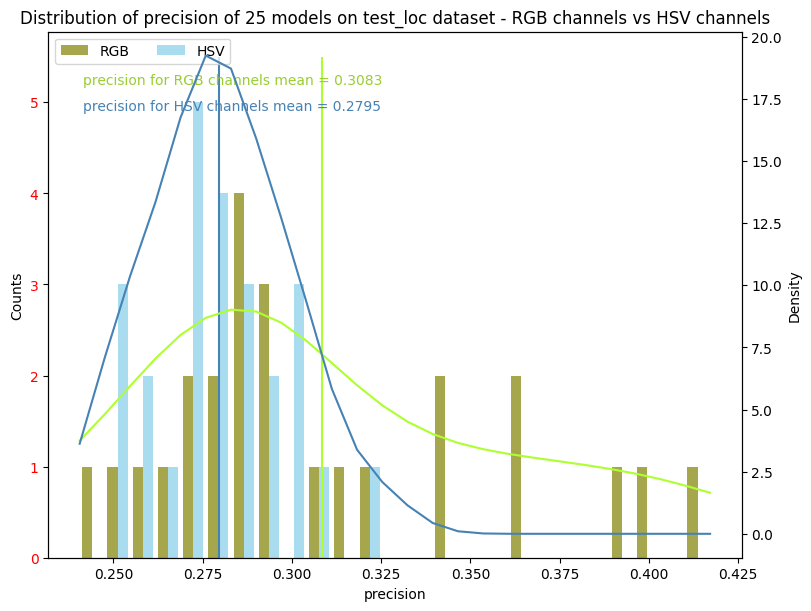

t test for HSV vs RGB channels: t-statistic = 2.80, p value = 0.0073


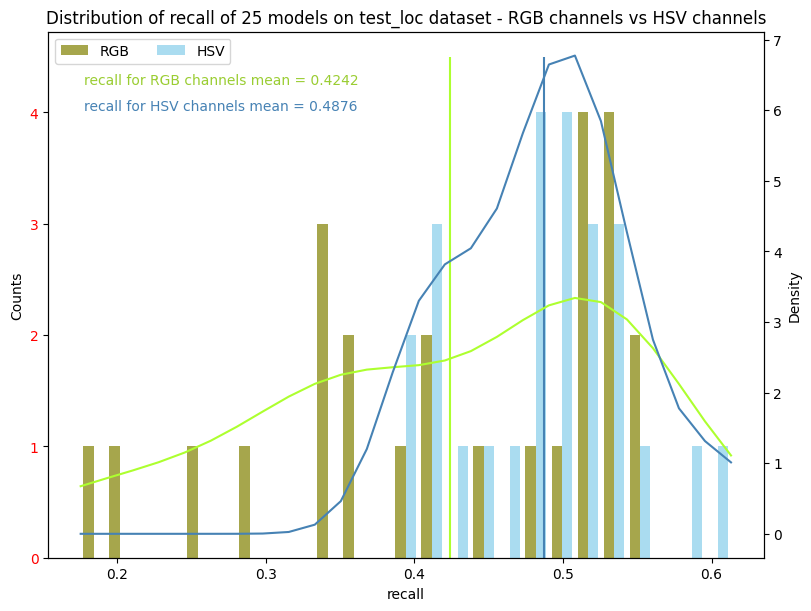

t test for HSV vs RGB channels: t-statistic = -2.50, p value = 0.0160


In [34]:
plot(df_mean_metrics_all, ch1 = 'RGB', ch2 = 'HSV', test_set = 'test_loc')

Null hypothesis is that the means are indistinguishable. 

Number of the data points for test set dataset: 25
Degrees of freedom = 48, Critical Value = 1.6772 



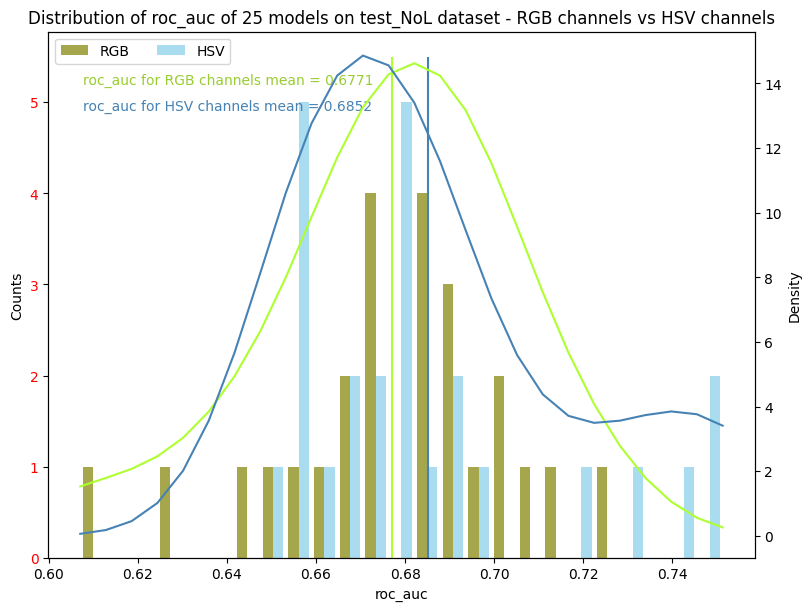

t-test for HSV vs RGB channels: t-statistic = -1.01, p value = 0.3195


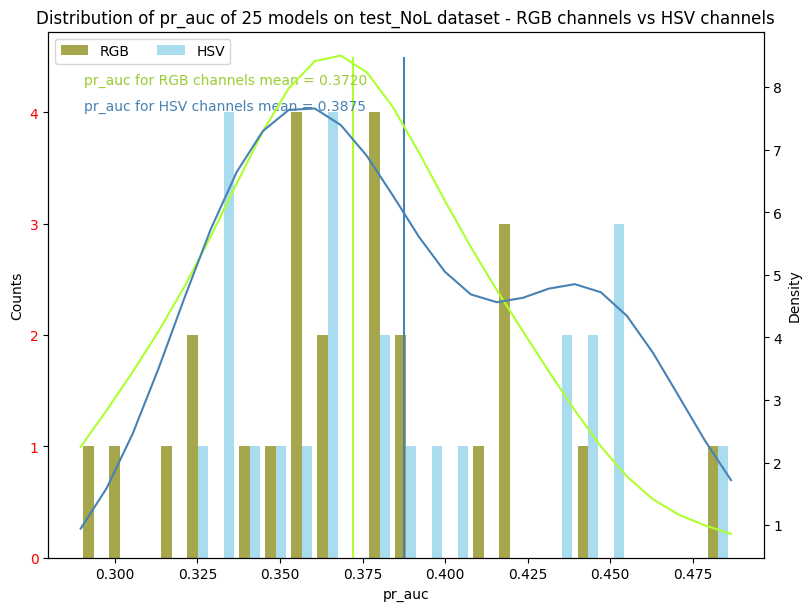

t-test for HSV vs RGB channels: t-statistic = -1.18, p value = 0.2433


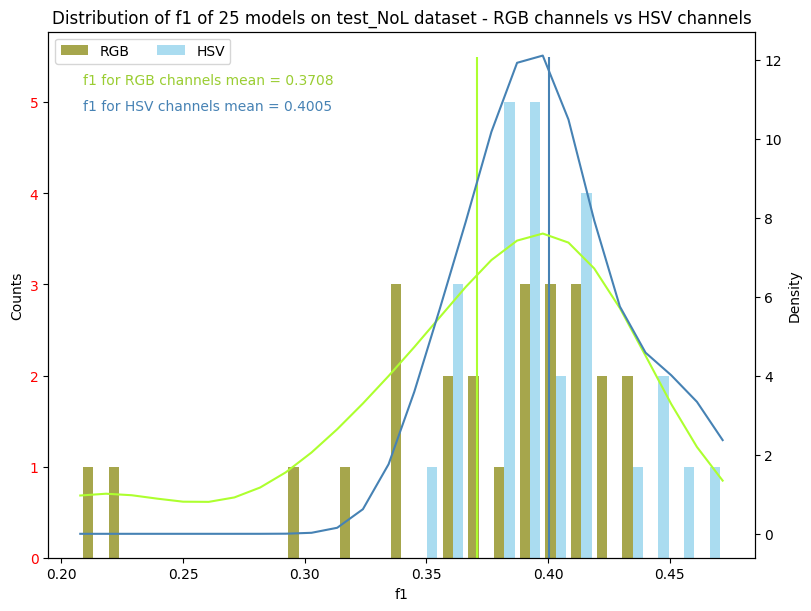

t-test for HSV vs RGB channels: t-statistic = -2.21, p value = 0.0319


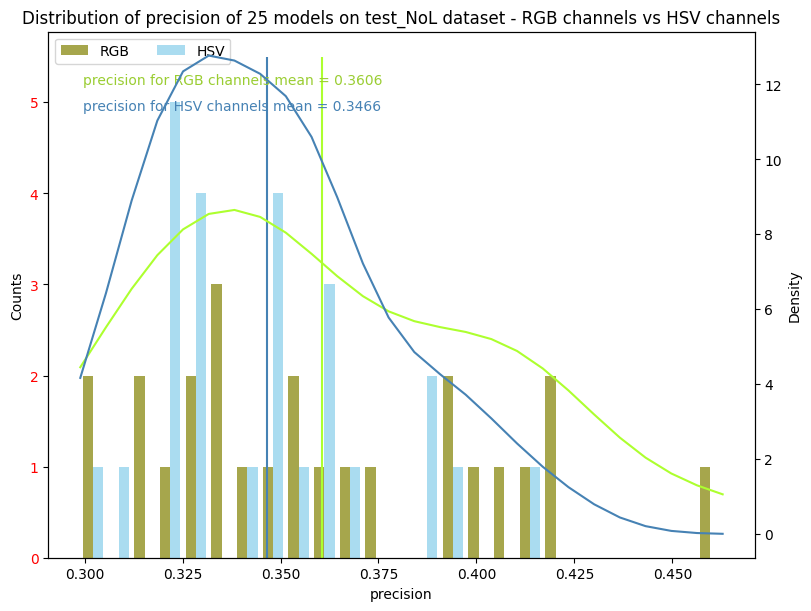

t-test for HSV vs RGB channels: t-statistic = 1.36, p value = 0.1804


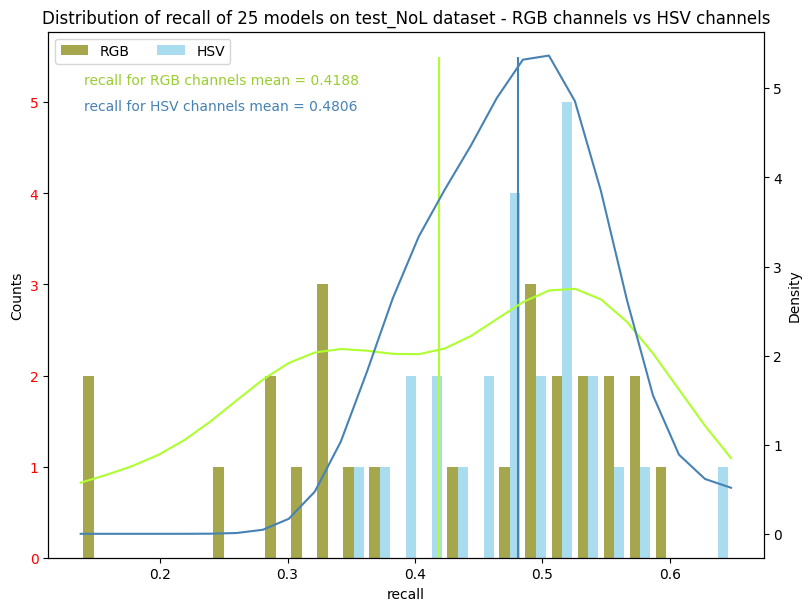

t-test for HSV vs RGB channels: t-statistic = -2.08, p value = 0.0428


In [36]:
plot(df_mean_metrics_all, ch1 = 'RGB', ch2 = 'HSV', test_set = 'test_NoL')